# Selection of lakes
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 03-12-2024<br>

**Introduction:**<br>
In this notebook, I select the lakes that will be modelled in GloFAS5. I analysed three datasets —GLoFAS4, [GLWD](https://www.sciencedirect.com/science/article/pii/S0022169404001404) and [HydroLakes](https://www.hydrosheds.org/products/hydrolakes)—, compare them, and select the most relevant lakes.

The final selection of lakes in GloFAS 5 contains:

1. Lakes alreday included in GloFAS4 (395):
    * 375 of those lakes are associated with a HydroLakes ID.
    * 20 of those lakes are only associated with GLWD.
2. A selection of lakes from HydroLakes (1746). This selection is based on some conditions:
    * The water body must be classified in HydroLakes as natural lake (`Lake_type == 1`)
    * The lake surface must be larger or equal than 50 km² (`Lake_area >= 50`)
    * The lake volume must be larger or equal than 100 hm3 (`Vol_total >= 100`)
    * The catchment area must be larger or equal than 500 km² (`Wshd_area >= 500`)

The selecion is based mostly on HydroLakes, as it is the most updated dataset, and it's the only one that includes lake volume. 

The total number of lakes above adds up to 2121. As this might be an excessively large number, I have created a field named PRIORITY (based on volume) that defines the order in which these lakes are to be added in GloFAS5:
* 0: lakes in GloFAS4
* 1: reservoirs needed to reach 90% of ghe global volume
* 2: reservoirs needed to reach 95% of ghe global volume
* 3: the rest

**To do:**
* [ ] Filter the `glwd_new` table to reduce the amount of lakes to add in GloFAS.
* [x] Do the previous filter by volume, similarly to the reservoirs.<br>
<font color='steelblue'>To do so, I needed to find a way to connect each GLWD lake with its corresponding lake in HydroLAKES. HydroLAKES includes two volume fields (`Vol_total`, `Vol_res`). Whereas `Vol_res` includes a minority of the lakes/reservoirs, `Vol_total` covers all the reservoirs. Unfortunately, the values in `Vol_total` seem hightly overestimated when compared with GRanD or the few volumne values available in GLWD.</font>
* [x] Is it of any interest to analyse HydroLAKES?<br>
<font color='steelblue'>Yes, since it's the only data set that includes volume.</font>
* [x] Include a filter by reservoir volume (that used in GloFAS) when loading the HydroLAKES points.<br>
<font color='steelblue'>All water bodies in HydroLAKES with area larger than 50 km² have also volume larger than 100 km³.</font>
* [x] Compute total volume from HydroLAKES. `Vol_total` using either all the points or relaxing the area limit of 50 km².

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
# import glob
import pandas as pd
import geopandas as gpd
# import dask.dataframe as dd
import dask_geopandas as dgpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
import yaml
from collections import OrderedDict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import select_reservoirs #, filter_reservoirs

In [4]:
def scientific_format(num):
    if num == 0:
        return '0'
    else:
        exponent = int(np.log10(abs(num)))
        prefix = num / 10**(exponent - 1)
        suffix = '⁰¹²³⁴⁵⁶⁷⁸⁹'[exponent]  # Unicode superscript digits for 0 to 9
        return f"{prefix:.0f}{suffix}"

## Configuration

In [5]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_GLOFAS5 = Path('Z:/nahaUsers/casadje/GloFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets')
PATH_GLWD = PATH_DATASETS / 'lakes' / 'GLWD' / 'level1'
PATH_HYLAK = PATH_DATASETS / 'lakes' / 'HydroLAKES' / 'LakeATLAS_v10_shp'

PATH_OUT = PATH_GLOFAS5 / 'lakes'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# selection limits
MIN_VOLUME = 100 # hm³
MIN_AREA = 50 # km²
MIN_CATCHMENT = 500 # km²

## GloFAS4

### Static maps

In [6]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

# load lake map
glofas_raster = xr.open_dataset(PATH_GLOFAS4 / 'static_maps' / '20220802_lakes_Global_03min.nc')['lakes']

# extract an array of IDs
aux = glofas_raster.where(glofas_raster != -9999, np.nan).where(~glofas_raster.isnull(), drop=True)
ids = np.unique(aux)
ids = [int(ID) for ID in ids[~np.isnan(ids)]]

# extract coordinates and catchment area
glofas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
glofas_area = pd.Series(index=ids, dtype=float)
for ID in tqdm(glofas_coords.index):
    cell = glofas_raster.where(glofas_raster == ID, drop=True)
    lon, lat = cell.lon.item(), cell.lat.item()
    glofas_coords.loc[int(ID)] = lon, lat
    glofas_coords.loc[ID] = lon, lat
    glofas_area.loc[int(ID)] = uparea.sel(x=lon, y=lat, method='nearest', tolerance=1e-4).item()
glofas_coords = glofas_coords.round(6)
glofas_area *= 1e-6 # convert area to km2

del aux, glofas_raster, uparea

  0%|          | 0/463 [00:00<?, ?it/s]

### Metadata

no. lakes in the metadata:	463
no. lakes in the raster:	463
lakes missing in the metadata:	[]
lakes missing in the raster:	[]
no. lakes in GloFAS:		463	(463 with A > 50 km²)
total lake area in GloFAS:	755377 km²
no. GloFAS4 lakes for which a HydroLakes ID was found:	442
no. GloFAS4 lakes for which a GRanD ID was found:	50


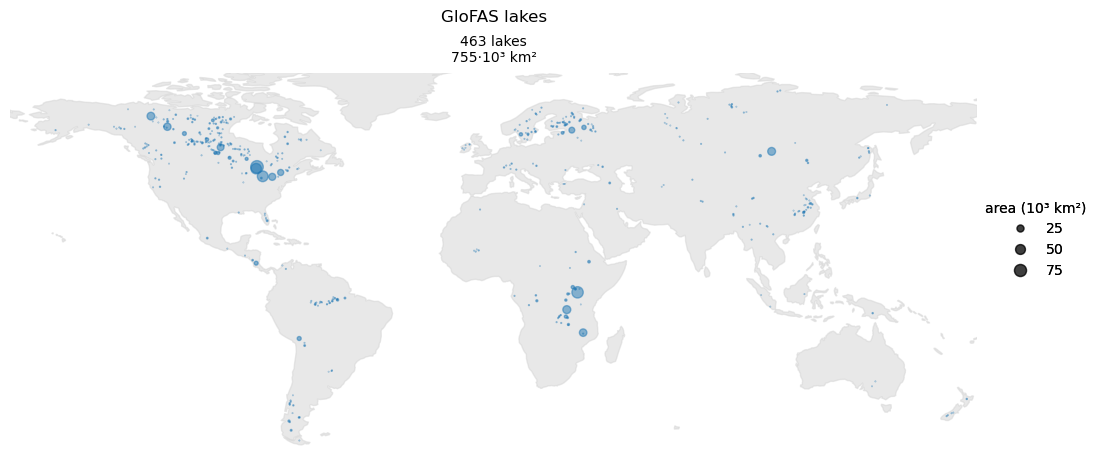

In [8]:
# load GloFAS4 metadata
glofas4 = pd.read_csv(PATH_GLOFAS4 / 'tables' / 'GLOFAS_HRES_lakes_metadata.csv', index_col='LakID')
glofas4 = glofas4.loc[glofas_coords.index.intersection(glofas4.index)]
glofas4.GLWD_ID = glofas4.GLWD_ID.astype('Int64')

# add catchment area (km2)
glofas4['CATCH_SKM'] = glofas_area

# add attributes from the tables used in LISFLOOD
for file in (PATH_GLOFAS4 / 'tables').glob('lake*.txt'):
    var = file.stem.split('_')[0][4:]
    try:
        df = pd.read_csv(file, sep='\t', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        glofas4[var] = df
    except:
        print(file)
        continue
        
# convert area to km2
glofas4['area'] /= 1e6
glofas4.rename(columns={'area': 'AREA_SKM', 'a': 'ALPHA'}, inplace=True)
glofas4.rename(columns={col: col.upper() for col in glofas4.columns if col != 'geometry'}, inplace=True)

# add HydroLakes IDs
with open('lakes_GloFAS4_HydroLakes.yaml', 'r') as file:
    map_glofas_hylak = yaml.safe_load(file)
glofas4['HYLAK_ID'] = glofas4.index.map(map_glofas_hylak).astype('Int64')

# add GRanD IDs
with open('lakes_GloFAS4_GRanD.yml', 'r') as file:
    map_glofas_grand = yaml.safe_load(file)
glofas4['GRAND_ID'] = glofas4.index.map(map_glofas_grand).astype('Int64')

# create geopandas.GeoDataFrame
glofas4 = gpd.GeoDataFrame(glofas4, geometry=[Point(xy) for xy in zip(glofas4.LISFLOODX3, glofas4.LISFLOODY3)], crs='EPSG:4326')
glofas4.index.name = 'LAK_ID'

print('no. lakes in the metadata:\t{0}'.format(glofas4.shape[0]))
print('no. lakes in the raster:\t{0}'.format(glofas_coords.shape[0]))
print('lakes missing in the metadata:\t{0}'.format(glofas_coords.index.difference(glofas4.index).to_list()))
print('lakes missing in the raster:\t{0}'.format(glofas4.index.difference(glofas_coords.index).to_list()))

# map of GloFAS lakes
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
scatter = ax.scatter(glofas4.geometry.x, glofas4.geometry.y, s=glofas4.AREA_SKM / 1000, alpha=.5)
ax.text(.5, 1.125, 'GloFAS lakes', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} lakes\n{1:.0f}·10³ km²'.format(glofas4.shape[0], glofas4.AREA_SKM.sum() / 1000)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .3, .1, .4], frameon=False)
ax.add_artist(legend2);

# save
plt.savefig(PATH_OUT / 'glofas_lakes.jpg', dpi=300, bbox_inches='tight')

print('no. lakes in GloFAS:\t\t{0}\t({1} with A > {2} km²)'.format(glofas4.shape[0], (glofas4.AREA_SKM >= MIN_AREA).sum(), MIN_AREA))
print('total lake area in GloFAS:\t{0:.0f} km²'.format(glofas4.AREA_SKM.sum()))
print('no. GloFAS4 lakes for which a HydroLakes ID was found:\t{0}'.format(glofas4.HYLAK_ID.notnull().sum()))
print('no. GloFAS4 lakes for which a GRanD ID was found:\t{0}'.format(glofas4.GRAND_ID.notnull().sum()))

>***Figure 1**. Lakes included in GloFAS. The size of the dots represents the lake area.*

In [12]:
# export shapefile
cols = ['GLWD_ID', 'HYLAK_ID', 'GRAND_ID', 'LAKE_NAME', 'COUNTRY', 'CONTINENT',
        'LONG_DEG', 'LAT_DEG', 'X_CORRECTE', 'Y_CORRECTE', 'X_COORD_AU', 'Y_COORD_AU', 'ZZ_NOTE_LO',
       'GLOFAS_STA', 'LISFLOODX3', 'LISFLOODY3', 'REMAP_COM', 
        'CATCH_SKM', 'AREA_SKM', 'AVINFLOW', 'ALPHA', 'geometry']
glofas4[cols].to_file(PATH_GLOFAS4 / 'tables' / 'GloFAS4_lakes.shp')

Area of the smallest lake:	50 km²


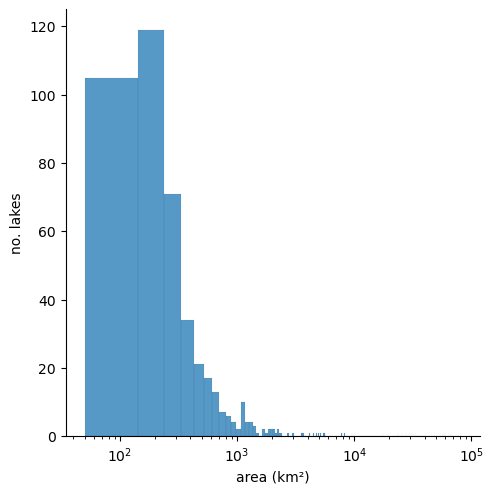

In [72]:
# distribution of the lake area
sns.displot(glofas4.AREA_SKM)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.0f} km²'.format(glofas4.AREA_SKM.min()))

>***Figure 2**. Lake surface area distribution in GloFAS.*

As explained in [Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671), only lakes with a minimum area of 50 km² are included in GloFAS.

## Global Lakes and Wetlands Database (GLWD)

GLWD ([Lehner et al., 2004](https://www.sciencedirect.com/science/article/pii/S0022169404001404)) is the only source of information about lakes currently included in GloFAS. GLWD includes polygons of the water bodies (either lakes or reservoirs); I will keep only lakes here.

Field `TYPE`:
* _Lake_
* _Reservoir_

Field `MGLD_TYPE`:
* _open_: lake with significant surface or subsurface outflow.
* _closed_: lake without significant surface or subsurface outflow (inland sink).
* _closedx_: lake probably without significant surface or subsurface outflow (inland sink).
* _res_: reservoir.

I will keep only lakes.

In [7]:
# import GLWD polygons
glwd_polygon = gpd.read_file(PATH_GLWD / 'glwd_1.shp').set_index('GLWD_ID', drop=True)
glwd_polygon.crs = 'EPSG:4326'

# keep only lakes
glwd_polygon = glwd_polygon.loc[(glwd_polygon.TYPE == 'Lake')] # & (glwd_polygon.MGLD_TYPE == 'open')]

# recompute catchment area in km² and volum in hm3
glwd_polygon.CATCH_TSKM *= 1000
glwd_polygon.VOLUME_CKM *= 1000
glwd_polygon.rename(columns={'CATCH_TSKM': 'CATCH_SKM', 'VOLUME_CKM': 'CAP_MCM'}, inplace=True)

# compute a mm equivalent inflow as the quotient between inflow volume and lake area
glwd_polygon['INFLOW_MM'] = glwd_polygon.INFLOW_CMS / glwd_polygon.AREA_SKM * 3600 * 24 * 365 * 1e-6 

# # fill in attributes of Lake Victoria
# glofas.loc[glofas.GLWD_ID.isnull(), ['GLWD_ID', 'CONTINENT']] = [3, 'Africa']
# cols = ['COUNTRY', 'LONG_DEG', 'LAT_DEG']
# glofas.loc[glofas.GLWD_ID.isnull(), cols] = glwd_polygon.loc[3, cols]

# add a boolean field whether the lake is already included in GloFAS or not
glwd_polygon['GloFAS'] = glwd_polygon.index.isin(glofas4.GLWD_ID)

# remove empty fields
glwd_polygon.dropna(axis=1, how='all', inplace=True)

# convert polygon GeoDataFrame to point GeoDataFrame
glwd_point = gpd.GeoDataFrame(glwd_polygon, geometry=[Point(xy) for xy in zip(glwd_polygon.LONG_DEG, glwd_polygon.LAT_DEG)], crs='EPSG:4326')

I had to remove the filter by `MGLD_TYPE == 'open'`, otherwise many lakes in GloFAS would be removed from the list of GWLD lakes. 

The source of 462 out of 463 lakes in GloFAS is GLWD. Out of those, 294 are classified as _open_, 26 as _closedx_ and 15 as _closed_ (the remaining 127 are not classified according to `MGLD_TYPE`). <font color='red'>It would be interesting to analyse why the closed lakes were included in GloFAS</font>. Only 1 lake in GloFAS does not have a `GLWD_ID`. It corresponds to lake Wapata (`LakID=460`). The metadata mentions that this lake was added after visual inspection in Google Maps.

no. lakes in GLWD:			3067	(3061 with A > 50 km²)
no. lakes in GLWD with volume data:	5	(308.0 km³)
total lake area in GLWD:		1684639 km²


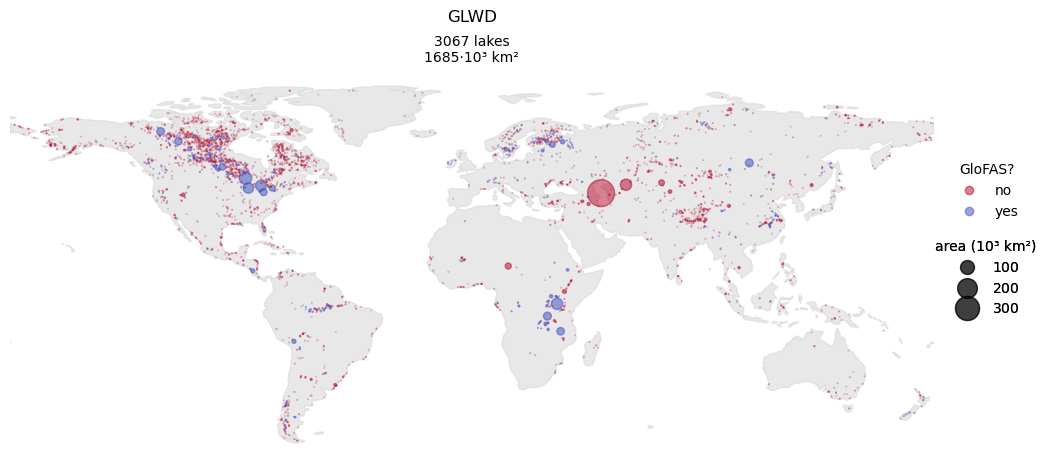

In [8]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
scatter = ax.scatter(glwd_point.geometry.x, glwd_point.geometry.y, s=glwd_point.AREA_SKM / 1000, cmap='coolwarm_r', c=glwd_point.GloFAS, alpha=.5)
ax.text(.5, 1.125, 'GLWD', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} lakes\n{1:.0f}·10³ km²'.format(glwd_point.shape[0], glwd_point.AREA_SKM.sum() / 1000)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.5)
labels1 = ['no', 'yes']
legend1 = ax.legend(handles1, labels1, title='GloFAS?', bbox_to_anchor=[1.005, .55, .1, .25], frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .35, .1, .25], frameon=False)
ax.add_artist(legend2);

plt.savefig(PATH_OUT / 'glwd_lakes.jpg', dpi=300, bbox_inches='tight')

print('no. lakes in GLWD:\t\t\t{0}\t({1} with A > {2} km²)'.format(glwd_point.shape[0], (glwd_point.AREA_SKM >= MIN_AREA).sum(), MIN_AREA))
mask_vol = ~glwd_point.CAP_MCM.isnull()
print('no. lakes in GLWD with volume data:\t{0}\t({1:.1f} km³)'.format(mask_vol.sum(), glwd_point[mask_vol].CAP_MCM.sum() / 1e3))
print('total lake area in GLWD:\t\t{0:.0f} km²'.format(glwd_point.AREA_SKM.sum()))

>***Figure 3**. Lakes in the GLWD data set. The dot size indicates the lake area. Blue dots are lakes included in GloFAS, whereas red dots are excluded from GloFAS.*

The GLWD data set includes 3067 lakes, all but 6 with a lake area larger than 50 km². It means that 2599 lakes in GLWD with area larger than 50 km² were filtered out of GloFAS for other reason (472 classified as _open_, 156 as _closed_ and 124 as _closedx_). 

In [9]:
mask_catchment = glwd_point.CATCH_SKM >= MIN_CATCHMENT
print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    glwd_point[mask_catchment].CAP_MCM.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = glwd_point.CAP_MCM >= MIN_VOLUME
print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    glwd_point[mask_volume].CAP_MCM.sum() * 1e-3,
    MIN_VOLUME
))

mask_area = glwd_point.AREA_SKM >= MIN_AREA
print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    glwd_point[mask_area].CAP_MCM.sum() * 1e-3,
    MIN_AREA
))

mask_cva = mask_catchment & mask_volume & mask_area
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, and area rules'.format(
    mask_cva.sum(),
    glwd_point[mask_cva].CAP_MCM.sum() * 1e-3,
))

 2263 lakes (308 km3) have a catchment larger than 500 km2
    5 lakes (308 km3) have a volume larger than 100 hm3
 3061 lakes (308 km3) have a surface area larger than 50 km2
    5 lakes (308 km3) comply with the catchment, volume, and area rules


The majority of the lakes in GLWD do not have a value of volume.

Area of the smallest lake:	43 km²


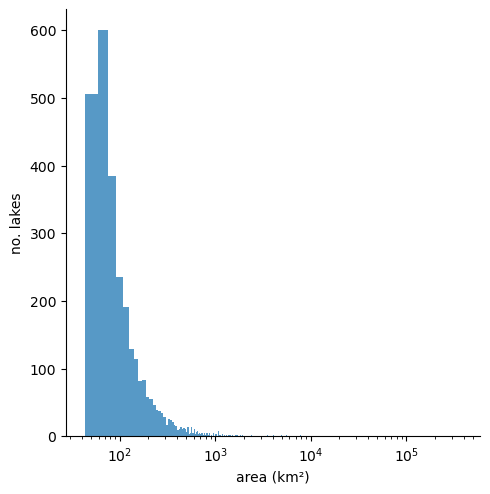

In [10]:
# distribution of the lake area
sns.displot(glwd_polygon.AREA_SKM)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.0f} km²'.format(glwd_polygon.AREA_SKM.min()))

>***Figure 4**. Lake surface area distribution in GLWD.*

## HydroLakes

HydroLAKES ([Messager et al., 2016](https://www.nature.com/articles/ncomms13603)) contains more than 1.4 million points of water bodies (both lakes, controlled lakes and reservoirs). 

Interesting fields:

* `Lake_type` indicates the type of water body:
    * 1: lake.
    * 2: reservoir.
    * 3: lake control
* `Lake_area`: surface area in km².
* `Vol_total`: total lake/reservoir volume in hm³.
* `Vol_res`: reported reservoir volume, or storage volume of added lake regulation (hm³)
* `Vol_src`: source of volume data:
    * 1: ‘Vol_total’ is the reported total lake volume from literature
    * 2: ‘Vol_total’ is the reported total reservoir volume from GRanD or literature
    * 3: ‘Vol_total’ is the estimated total lake volume using the geostatistical modeling approach by Messager et al. (2016)
* `Depth_avg`: average depth in m.
* `Dis_avg`: average long-term discharge (m3).
* `Res_time`: average residence time in days.
* `Wshd_area`: area of the lake's watershed in km2.
* `Pour_long` and `Pour_lat` are the coordinates of the pour point in decimal degrees.
* `dis_m3_pyr`: annual average natural discharge.

**Analysis of volume data in HydroLAKES**

The HydroLakes data set contains three fields with volume data:

* *Vol_total*: Total lake or reservoir volume, in million cubic meters (1 mcm = 0.001 km3). For most polygons, this value represents the total lake volume as estimated using the geostatistical modeling approach by Messager et al. (2016). However, where either a reported lake volume (for lakes ≥ 500 km2) or a reported reservoir volume (from GRanD database) existed, the total volume represents this reported value. In cases of regulated lakes, the total volume represents the larger value between reported reservoir and modeled or reported lake volume. Column ‘Vol_src’ provides additional information regarding these distinctions.
* *Vol_res*: Reported reservoir volume, or storage volume of added lake regulation, in million cubic meters (1 mcm = 0.001 km3). 0: no reservoir volume
* *Vol_src*:
    * 1: ‘Vol_total’ is the reported total lake volume from literature
    * 2: ‘Vol_total’ is the reported total reservoir volume from GRanD or literature
    * 3: ‘Vol_total’ is the estimated total lake volume using the geostatistical modeling approach by Messager et al. (2016)

In the following cell I will analyse the volume data contained in columns `Vol_total` and `Vol_res` to identify which one of the two sources is more reliable.

**The volume estimates in the columns `Vol_total` and `Vol_res` differ notably (in the order of 7 times more in `Vol_total`)**. Less than 1 in 5 water bodies contain data in the `Vol_res` column, which seems to be the most consistent field compared with the data in GRanD and GLWD.

**Global lake area and lake volume**

As a reference for comparison, I will compute the total area and total volume of all natural lakes in HydroLAKES. Since HydroLAKES is the data set with the largest amount of water bodies, these would be considered as the most representative global values.

**Filter HydroLAKES**

I will load the complete set of water bodies in HydroLAKES (over 1.4 million) and filter by two conditions:
* `Lake_area` larger or equal than 50 km² established in GloFAS.
* `Lake_type`. I keep only natural lakes (1).

In [11]:
# columns to be used from HydroATLAS
hylak_cols = ['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src', 'Lake_type', 'Lake_area', #'Grand_id',
              'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_src', 'Depth_avg', 'Dis_avg', #'Vol_res', 
              'Res_time', 'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat', 'dis_m3_pyr']

if 'totals' in locals():
    del totals
if 'hylak_pnt' in locals():
        del hylak_pnt
for file in PATH_HYLAK.glob('*_v10_pnt_*.shp'):
    # load HydroLAKES
    ddf = dgpd.read_file(file, columns=hylak_cols + ['geometry'], npartitions=10)
    # remove reservoirs and small lakes
    mask_lakes = ddf.Lake_type.isin([1])
    mask_area = ddf.Lake_area >= MIN_AREA #([1, 2, 3]) #([1, 3])
    # compute totals
    totals_i = ddf.loc[mask_lakes, ['Lake_area', 'Vol_total']].sum(axis=0).compute()
    totals_i.loc['n_lakes'] = ddf.shape[0].compute()
    if 'totals' in locals():
        totals = pd.concat([totals, totals_i], axis=1).sum(axis=1)
    else:
        totals = totals_i
    # filter relevant lakes
    df = ddf.loc[mask_lakes & mask_area].compute()
    if 'hylak_pnt' not in locals():
        hylak_pnt = df
    else:
        hylak_pnt = pd.concat([hylak_pnt, df])
    del ddf, mask_lakes, mask_area, df, totals_i

hylak_pnt.set_index('Hylak_id', drop=True, inplace=True)

print('All natural lakes in HydroLAKES have the following totals:')
print('no. lakes:\t{2:.0f}\narea:\t\t{0:.0f} km²\nVol_total:\t{1:.0f} hm³'.format(*totals))

All natural lakes in HydroLAKES have the following totals:
no. lakes:	1427688
area:		2471784 km²
Vol_total:	152474394 hm³


The two volume fields (`Vol_total` , `Vol_res`) render very different values of volume. As we will see later on, `Vol_total` is provided for all entries in the data set, whereas `Vol_res` is only provided for a minority of entries. When compared against GRanD or GLWD, the values in `Vol_res` seem more reliable, whereas those in `Vol_total` seem to overestimate the volume.

So far, we can only compare the area totals from GloFAS and GLWD with HydroLAKES. **GloFAS includes 755·10³ km2 30% of HydroLAKES)**, **GLWD represents 1,685·10³ km2 (68%)**, and the **selection of lakes in HydroLakes 1,480·10³ km2 (60%)**.

In [12]:
# # load selection of HydroLAKES
# hylak_pnt_shp = PATH_OUT / 'LakeATLAS_v10_pnt_filter.shp'
# if hylak_pnt_shp.is_file():
#     hylak_pnt = gpd.read_file(hylak_pnt_shp).set_index('Hylak_id', drop=True)
# else:

#     if 'hylak_pnt' in locals():
#         del hylak_pnt
#     for file in PATH_HYLAK.glob('*_v10_pnt_*.shp'):
#         # load HydroLAKES
#         ddf = dgpd.read_file(file, columns=cols, npartitions=10)
#         # remove reservoirs and small lakes
#         mask_lakes = ddf.Lake_type.isin([1]) #([1, 2, 3]) #([1, 3])
#         mask_area = ddf.Lake_area >= MIN_AREA
#         ddf = ddf.loc[mask_lakes & mask_area]
#         # compute and convert into geopandas
#         df = ddf.compute()
#         if 'hylak_pnt' not in locals():
#             hylak_pnt = df
#         else:
#             hylak_pnt = pd.concat([hylak_pnt, df])
#         del ddf, mask_lakes, mask_area, df
#     hylak_pnt = gpd.GeoDataFrame(hylak_pnt, geometry=[Point(xy) for xy in zip(hylak_pnt.Pour_long, hylak_pnt.Pour_lat)], crs='EPSG:4326')
#     hylak_pnt.set_index('Hylak_id', drop=True, inplace=True)

#     # exportar
#     hylak_pnt.to_file(hylak_pnt_shp, driver='ESRI Shapefile')

no. lakes:		2715
total lake area:	1479761 km²	(60% total)
total lake volume:	146253253 hm³	(96% total)


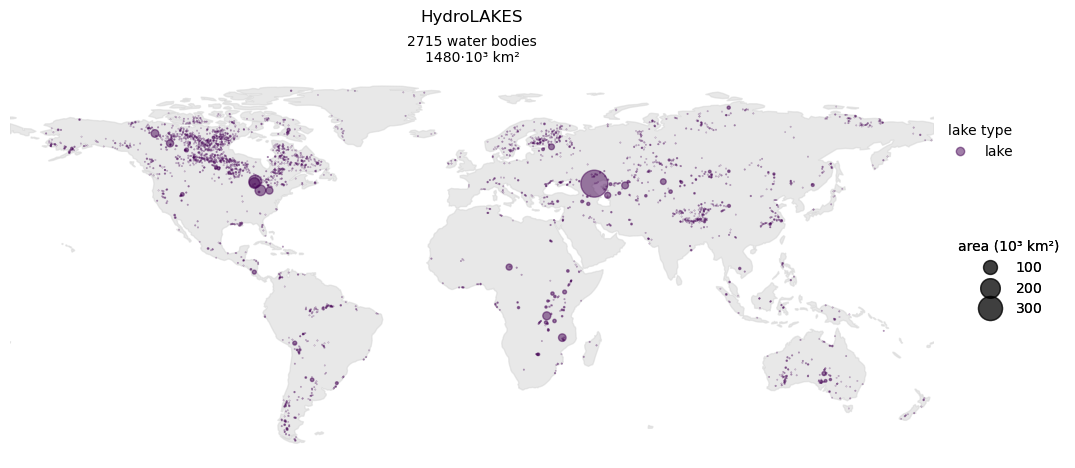

In [24]:
r = 1000
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
scatter = plt.scatter(hylak_pnt.geometry.x, hylak_pnt.geometry.y, s=hylak_pnt.Lake_area / r,
                      alpha=.5, cmap='viridis', c=hylak_pnt.Lake_type)
ax.text(.5, 1.125, 'HydroLAKES', horizontalalignment='center', verticalalignment='bottom',
        transform=ax.transAxes, fontsize=12)
text = '{0} water bodies\n{1:.0f}·{2} km²'.format(hylak_pnt.shape[0], hylak_pnt.Lake_area.sum() / r, scientific_format(r))
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.5)
labels1 = ['lake', 'reservoir', 'control lake']
legend1 = ax.legend(handles1, labels1, title='lake type', bbox_to_anchor=[1.0, .65, .08, .25], frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area ({0} km²)'.format(scientific_format(r)),
                    bbox_to_anchor=[1.05, .35, .1, .25], frameon=False)
ax.add_artist(legend2);

# plt.savefig(PATH_OUT / 'HydroLakes_lakes.jpg', dpi=300, bbox_inches='tight')

print('no. lakes:\t\t{0}'.format(hylak_pnt.shape[0]))
print('total lake area:\t{0:.0f} km²\t({1:.0f}% total)'.format(hylak_pnt.Lake_area.sum(), hylak_pnt.Lake_area.sum() / totals.Lake_area * 100))
print('total lake volume:\t{0:.0f} hm³\t({1:.0f}% total)'.format(hylak_pnt.Vol_total.sum(), hylak_pnt.Vol_total.sum() / totals.Vol_total * 100))

>***Figure 4**. Water bodies in the HydroLAKES data set with surface area exceeding 50 km². The dot size indicates the lake area, and the dot colour the type of water body.*

Filtering the HydroLAKES by a minimum area reduces the number of items from 1.4 million to only 3402. This drastic reduction represents, however, 60% of the global lake area and approximately 96% of the volume.

## Selection of lakes
### Conditions

In [25]:
mask_area = hylak_pnt.Lake_area >= MIN_AREA
mask_catchment = hylak_pnt.Wshd_area >= MIN_CATCHMENT
mask_volume = hylak_pnt.Vol_total >= MIN_VOLUME
mask_all = mask_catchment & mask_volume & mask_area

print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    hylak_pnt[mask_area].Vol_total.sum() * 1e-3,
    MIN_AREA
))
print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    hylak_pnt[mask_catchment].Vol_total.sum() * 1e-3,
    MIN_CATCHMENT
))
print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    hylak_pnt[mask_volume].Vol_total.sum() * 1e-3,
    MIN_VOLUME
))
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, and area rules'.format(
    mask_all.sum(),
    hylak_pnt[mask_all].Vol_total.sum() * 1e-3,
))

# selection of lakes and accumulated volume
hylak_pnt_sel = hylak_pnt[mask_all].copy()

 2715 lakes (146253 km3) have a surface area larger than 50 km2
 2227 lakes (145664 km3) have a catchment larger than 500 km2
 2625 lakes (146246 km3) have a volume larger than 100 hm3
 2163 lakes (145659 km3) comply with the catchment, volume, and area rules


### Overlap with GloFAS rivers
To make sure that the lakes that will be included in GloFAS5 are connected to the river network, I've done a further check. From the _upstream area_ map I created a polygon layer that contains all pixels in GloFAS with at least a catchment area of 500 km2. I intersect that polygon layer with the HydroLakes polygons of selected lakes, and keep only those that overlap.

In [32]:
if 'hylak_pol_sel' in locals():
        del hylak_pol_sel
for file in PATH_HYLAK.glob('*_v10_pol_*.shp'):
    # load HydroLAKES
    ddf = dgpd.read_file(file, columns=hylak_cols + ['geometry'], npartitions=10)
    # remove reservoirs and small lakes
    mask_lakes = ddf.Lake_type.isin([1])
    mask_area = ddf.Lake_area >= MIN_AREA #([1, 2, 3]) #([1, 3])
    # filter relevant lakes
    df = ddf.loc[mask_lakes & mask_area].compute()
    df.set_index('Hylak_id', drop=True, inplace=True)
    idx = df.index.intersection(hylak_pnt_sel.index)
    df = df.loc[idx]
    if 'hylak_pol_sel' not in locals():
        hylak_pol_sel = df
    else:
        hylak_pol_sel = pd.concat([hylak_pol_sel, df])
    del ddf, mask_lakes, mask_area, df

# filter lakes that intersect GloFAS pixels with at least 500 km² upstream area
glofas_rivers = gpd.read_file(PATH_OUT / 'GloFAS_rivers_500skm.shp')
mask = hylak_pol_sel.geometry.apply(lambda x: glofas_rivers.geometry.intersects(x).any())

hylak_pnt_sel = hylak_pnt_sel[mask]
hylak_pol_sel = hylak_pol_sel[mask]

print('{0} lakes were selected after intersection with the GloFAS upstream area map > 500 km²'.format(mask.sum()))

In [149]:
# # load HydroLake polygons and apply selection
# hylak_pol = gpd.read_file(PATH_OUT / 'LakeATLAS_v10_pol_filter.shp').set_index('Hylak_id', drop=True)
# hylak_pol_sel = hylak_pol.loc[hylak_pol.index.intersection(hylak_sel.index)]

In [34]:
# export
hylak_pnt_sel.to_file(PATH_OUT / 'LakeATLAS_v10_pnt_selection.shp')
hylak_pol_sel.to_file(PATH_OUT / 'LakeATLAS_v10_pol_selection.shp')

### Add GLWD attributes

In GIS, I intesected the polygons in HydroLakes and GLWD to map the lake IDs in these two data sets. In the following code, I import that intersection and use it to add GLWD attributes (`GLWD_ID` and `MGLWD_TYPE`) to the selected lakes.

In [82]:
# load the polygon layer of the intersection between HydroLakes and GLWD
hydrolakes_glwd = gpd.read_file(PATH_OUT / 'LakeATLAS_GLWD_intersection.shp')
hydrolakes_glwd = hydrolakes_glwd[['Hylak_id', 'GLWD_ID', 'Lake_name', 'LAKE_NAME_', 'Lake_area', 'AREA_SKM', 'Vol_total', 'area_int', 'MGLD_TYPE', 'geometry']]
hydrolakes_glwd.set_index('Hylak_id', drop=False, inplace=True)
hydrolakes_glwd.rename(columns={'Lake_name': 'Hylak_name', 'LAKE_NAME_': 'GLWD_name', 'Lake_area': 'Hylak_area', 'AREA_SKM': 'GLWD_area'}, inplace=True)
hydrolakes_glwd.GLWD_name = hydrolakes_glwd.GLWD_name.str.replace("Lake ", "", regex=False)
print('{0} intersected polygons'.format(hydrolakes_glwd.shape[0]))

3004 intersected polygons


In [83]:
# # connection Hylak with one or multiple GLWD
# map_hylak_glwd = {}
# for hylak_id in hydrolakes_glwd.index.unique():
#     try:
#         map_hylak_glwd[hylak_id] = hydrolakes_glwd.loc[hylak_id, 'GLWD_ID'].to_list()
#     except:
#         map_hylak_glwd[hylak_id] = hydrolakes_glwd.loc[hylak_id, 'GLWD_ID']
# map_hylak_glwd = OrderedDict(sorted(map_hylak_glwd.items()))

In [84]:
for hylak_id in hylak_pnt_sel.index:
    if hylak_id not in hydrolakes_glwd.index:
        # print(f'Hylak {hylak_id} not in the intersection with GLWD')
        continue
    df = hydrolakes_glwd.loc[[hylak_id]]
    if df.shape[0] == 1:
        hylak_pnt_sel.loc[hylak_id, 'GLWD_ID'] = df.GLWD_ID.values[0]
        hylak_pnt_sel.loc[hylak_id, 'MGLD_TYPE'] = df.MGLD_TYPE.values[0]
    else:
        mask_name = df.Hylak_name == df.GLWD_name
        if mask_name.sum() == 1:
            hylak_pnt_sel.loc[hylak_id, 'GLWD_ID'] = df[mask_name].GLWD_ID.values[0]
            hylak_pnt_sel.loc[hylak_id, 'MGLD_TYPE'] = df[mask_name].MGLD_TYPE.values[0]
        else:
            i = df.area_int.argmax()
            hylak_pnt_sel.loc[hylak_id, 'GLWD_ID'] = df.iloc[i].GLWD_ID
            hylak_pnt_sel.loc[hylak_id, 'MGLD_TYPE'] = df.iloc[i].MGLD_TYPE
            
hylak_pnt_sel.MGLD_TYPE.value_counts()

open       657
closed     135
closedx    120
res          8
Name: MGLD_TYPE, dtype: int64

### Merge lakes from GloFAS4 and HydroLakes

In [96]:
cols = ['LAK_ID', 'GLWD_ID', 'HYLAK_ID', 'LAKE_NAME', 'COUNTRY', 'AREA_SKM', 'CAP_MCM', 'CATCH_SKM', 'MGLD_TYPE']

# selection of lakes from GloFAS4 to be kept
glofas4['MGLD_TYPE'] = glofas4.GLWD_ID.map(glwd_point.MGLD_TYPE)
# from_glofas4 = glofas4[glofas4.GRAND_ID.isnull() & glofas4.HYLAK_ID.isnull()].copy()
from_glofas4 = glofas4[glofas4.GRAND_ID.isnull() & ~glofas4.HYLAK_ID.isin(hylak_pnt_sel.index)].copy()
from_glofas4['CAP_MCM'] = np.nan
mask = from_glofas4.HYLAK_ID.notnull()
from_glofas4.loc[mask, 'CAP_MCM'] = from_glofas4[mask].HYLAK_ID.map(hylak_pnt.Vol_total)
from_glofas4 = from_glofas4[from_glofas4.columns.intersection(cols).tolist() + ['geometry']]
# from_glofas4.index.name = 'LAK_ID'
from_glofas4.reset_index(inplace=True)

# selection of lakes from Hylak to be added
from_hylak = hylak_pnt_sel.copy()
from_hylak.reset_index(inplace=True)
from_hylak.columns = [col.upper() if col != 'geometry' else col for col in from_hylak.columns]
from_hylak.rename(columns={'LAKE_AREA': 'AREA_SKM', 'VOL_TOTAL': 'CAP_MCM', 'WSHD_AREA': 'CATCH_SKM'}, inplace=True)
from_hylak['LAK_ID'] = from_hylak.HYLAK_ID.map({hylak_id: glofas_id for glofas_id, hylak_id in map_glofas_hylak.items()})
from_hylak = from_hylak[from_hylak.columns.intersection(cols).tolist() + ['geometry']]

# merge the two sources
glofas5 = pd.concat((from_glofas4, from_hylak), axis=0)
glofas5 = glofas5[cols + ['geometry']]
int_cols = ['LAK_ID', 'GLWD_ID', 'HYLAK_ID']
glofas5[int_cols] = glofas5[int_cols].astype('Int64')
glofas5.sort_values('AREA_SKM', ascending=False, inplace=True)
# glofas5.reset_index(inplace=True)
glofas5.index.name = 'FID'

glofas5.head()                                                         

C:\DEV\Anaconda3\envs\xr\lib\site-packages\pandas\core\arrays\masked.py:395: RuntimeWarning: invalid value encountered in cast
  data = self._data.astype(dtype.numpy_dtype, copy=copy)


,LAK_ID,GLWD_ID,HYLAK_ID,LAKE_NAME,COUNTRY,AREA_SKM,CAP_MCM,CATCH_SKM,MGLD_TYPE,geometry
FID,,,,,,,,,,
0,<NA>,1,1,Caspian Sea,Russia,377002.0,75600000.0,1404110.0,closedx,POINT (47.71771 45.59193)
910,116,2,5,Superior,United States of America,81843.9,12004000.0,209220.0,open,POINT (-84.46055 46.46859)
912,117,5,8,Huron,United States of America,59399.3,3550000.0,576018.0,open,POINT (-82.42258 42.99940)
911,118,6,6,Michigan,United States of America,57726.8,4860000.0,176006.0,open,POINT (-84.75391 45.82292)
6,282,7,17,Tanganyika,Democratic Republic of the Congo,32826.6,18940000.0,239412.0,open,POINT (29.18542 -5.91118)


#### Prioritise

I will create a column `PRIORITY` in the selected lakes that defines in which order they should be added to GloFAS5:
* 0: lakes already in GloFAS4
* 1: lakes needed to reach 90% of the global volume
* 2: lakes needed to reach 95% of the global volume
* 3: the rest

In [97]:
mask_in_glofas4 = glofas5.LAK_ID.notnull()
glofas5.loc[mask_in_glofas4, 'PRIORITY'] = 0
glofas_volume = glofas5[mask_in_glofas4].CAP_MCM.sum()
total_volume = totals.Vol_total
print('GloFAS4 lakes add up to {0:.1f}% of the total lake volume'.format(glofas_volume / total_volume * 100))
print('GloFAS5 lakes add up to {0:.1f}% of the total lake volume'.format(glofas5.CAP_MCM.sum() / total_volume * 100))

priorities = {
    3: .975,
    2: .95,
    1: .9,
}
for priority, proportion in priorities.items():
    
    # storage capacity to be added in GloFAS to reach the target
    target_volume = proportion * total_volume - glofas_volume

    selection = select_reservoirs(
        glofas5[~mask_in_glofas4], 
        sort='CAP_MCM', 
        storage='CAP_MCM', 
        target=target_volume,
        plot=False
    )
    glofas5.loc[selection.index, 'PRIORITY'] = priority
glofas5.PRIORITY = glofas5.PRIORITY.astype(int)
print(glofas5.PRIORITY.value_counts().sort_index().cumsum())

GloFAS4 lakes add up to 38.4% of the total lake volume
GloFAS5 lakes add up to 95.5% of the total lake volume
0     387
1     391
2    1023
3    2151
Name: PRIORITY, dtype: int64


In [99]:
# export GloFAS5 lakes as points
glofas5.to_file(PATH_OUT / 'GloFAS5_lakes_pnt.shp')